## Laplace

In this notebook we see how well the NN with dropout performs on laplace prior

(can easily copy and paste this format for other priors - just define the appropriate functions in MainCode)

In [2]:
import sys, pathlib, os

CODE_DIR = pathlib.Path(os.getcwd())  / "MainCode"
if CODE_DIR.exists():
    sys.path.append(str(CODE_DIR.resolve()))
else:
    raise FileNotFoundError("Code directory not found")

# Module imports
from generate_data import make_laplace_simulator, make_dataset
from NN import NN
from plotting_functions.plot_single_dataset_posterior import make_posterior_plotter
from plotting_functions.plot_training_loss import plot_loss
from performance_metrics.average_relative_error import make_avg_rel_error_fn

# External imports
from tensorflow.keras.callbacks import EarlyStopping
from functools import partial

print("successfully imported all modules")


successfully imported all modules


In [3]:
no_params = 10
epochs = 200
patience_early_stopping = 10
no_examples = 20_000
batch_size = 128

sim_cfg = dict(
    no_params     = no_params,
    n_per_sample  = 1000,
    noise_std     = 0.2,
    batch_size = batch_size
)

NN_cfg = dict(
    no_params = no_params,
    neurons = [128, 128],
    dropout_probs =  [0.2, 0.2],
    always_on_dropout = True
)

### Generate data

In [4]:
laplace_simulator = make_laplace_simulator(0,1, **sim_cfg)
laplace_train = make_dataset(int(0.9*no_examples), laplace_simulator, sim_cfg["batch_size"])
laplace_val = make_dataset(int(0.1*no_examples), laplace_simulator, sim_cfg["batch_size"])

### NN for Laplace

In [5]:
laplace_NN = NN(**NN_cfg)
laplace_NN.norm.adapt(laplace_train.map(lambda x, y: x))
laplace_NN.compile(loss='mse', optimizer="adam")

2025-06-26 21:55:37.996365: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Fit NN

Epoch 1/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7772 - val_loss: 0.6691
Epoch 2/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5607 - val_loss: 0.3665
Epoch 3/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3305 - val_loss: 0.2677
Epoch 4/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2521 - val_loss: 0.2255
Epoch 5/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2196 - val_loss: 0.2075
Epoch 6/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2043 - val_loss: 0.1969
Epoch 7/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1949 - val_loss: 0.1880
Epoch 8/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1877 - val_loss: 0.1871
Epoch 9/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1867 - val_loss: 0.1849
Epoch 10/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1830 - val_loss: 0.1809
Epoch 11/200
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1826 - val_loss: 0.1774
Epoch 12/200
140/140 ━━━━━━━━━━━━━━━━━━━━

Model: "NN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_norm (Normalization)      │ (None, 121)            │           243 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,499 (392.58 KB)

 Trainable params: 33,418 (130.54 KB)

 Non-trainable params: 243 (976.00 B)

 Optimizer params: 66,838 (261.09 KB)

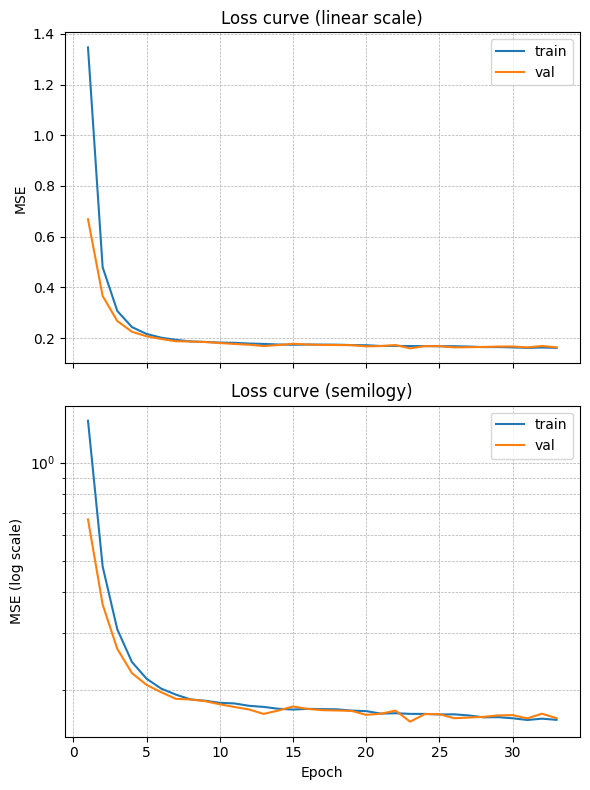

In [6]:
history = laplace_NN.fit(
    laplace_train.batch(batch_size),
    validation_data=laplace_val.batch(batch_size),
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience_early_stopping,
                             restore_best_weights=True)]
)
laplace_NN.summary()
plot_loss(history)

In [7]:
laplace_avg_rel_error = make_avg_rel_error_fn(laplace_simulator,
                                              batchsize   = batch_size,
                                              no_tests    = 2_000,
                                              mc_samples  = 30)

In [8]:
e_laplace = laplace_avg_rel_error(model=laplace_NN)
print(f"Laplace test error : {e_laplace:.4f}")

Laplace test error : 0.1334


In [9]:
laplace_plot = make_posterior_plotter(
    simulate_batch=laplace_simulator,
    no_params=no_params,
    mc_samples=10_000,
    bins=40,
    show_mc_stats=True
)

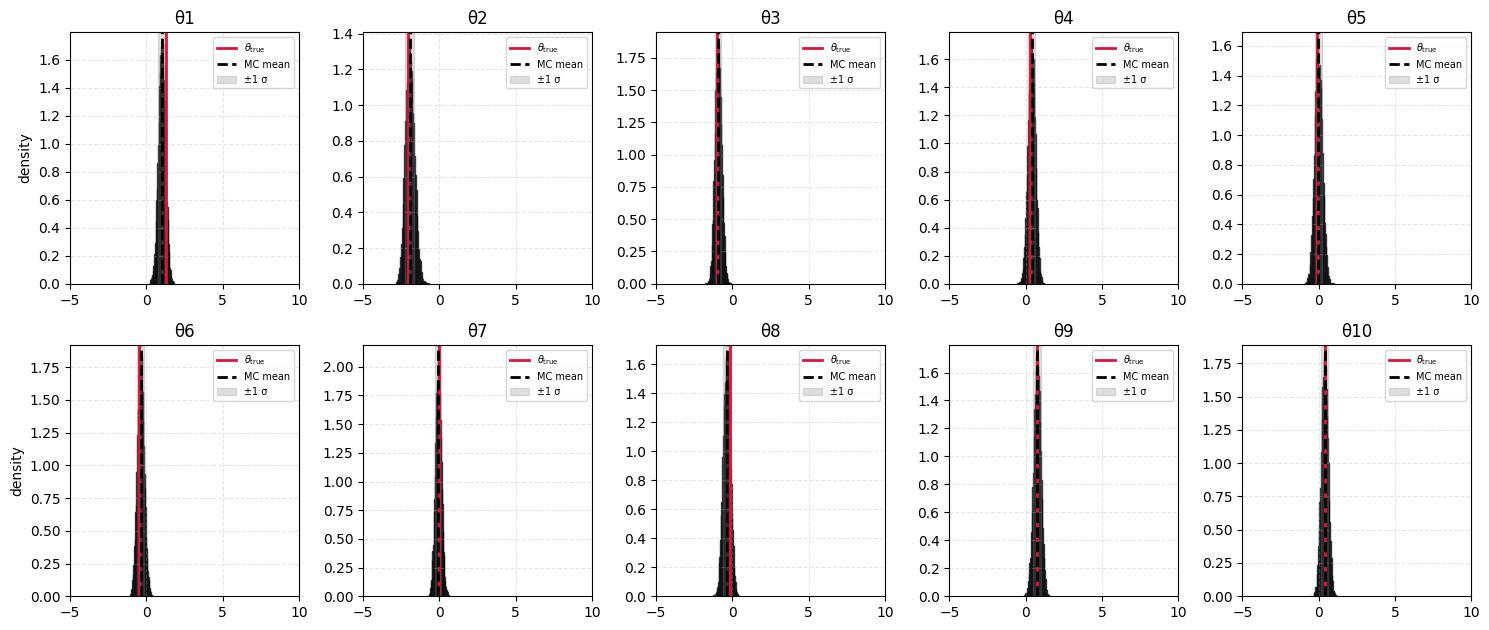

In [10]:
laplace_plot(model=laplace_NN)